# Reinforcement Learning with Neural Netowrks as Q learning

## The Cart Pole problem 

![CartPoleUrl](https://gymnasium.farama.org/_images/cart_pole.gif "CartPole")

<img src="fig/cp.png" width=400 height=400 />

## Environment, actions, states, rewards

The state is represented by 4 numbers:

- The cart position x from -2.4 to 2.4.
- The cart velocity v
- The pole angle θ with respect to the vertical from -12 to 12 degrees (from -0.21 to 0.21 in radians)
- The pole angular velocity ω. This is the rate of change of θ.

What about the actions our agent can perform?

- 0 : Push the cart to the left.
- 1 : Push the cart to the right.

The reward is +1 for every step taken. This means that the longer the agent keeps the pole standing, the higher the cumulative reward.

### Parametric Q-learning

The state-space for the CartPole consists of 4 continuous numbers

<img src="fig/ps.png" width=200 height=200 />

In a continuous state space like this, we represent the optimal Q-value function using a parametric form

<img src="fig/vp.png" width=200 height=200 />

where

- Q* is a model architecture, like a linear model, or a very deep feed-forward neural network.
- We estimate the set of parameters __$P = (p_{1},p_{2},...,p_{m})$__ using the experiences __(s, a, r, s’)__ the agent collects during training

#### How do you learn the vector of parameter P?

<img src="fig/pbell.png" width=300 height=300 />

the function Q*(s, a, P) satisfies the Bellman optimality equation, a key equation in Reinforcement Learning

<img src="fig/popt.png" width=300 height=300 />

that tells us that the maximum future reward __Q*(s, a, P)__ is the reward r the agent receives for entering the current state __s__ plus the maximum future reward for the next state __s’__ .

The optimal parameters P* are those that bring the left-hand side of this equation as close as possible to the right-hand side.


This is an optimization problem that you can solve with modern Machine Learning techniques. More precisely, Supervised Machine Learning techniques.


A supervised ML problem has 3 ingredients:


- the input features and corresponding targets
- a set of parameters we need to determine
- a model architecture that depends on these parametersand that maps features to model outputs


The goal is to find the parameters that make the model outputs match the target values

<img src="fig/qft.png" width=400 height=400 />

In other words, we want to find the parameters P* that minimize the distance, aka loss in the ML jargon.

<img src="fig/qpd.png" width=400 height=400 />

Given your current estimate P⁰, a mini-batch of experiences (s, a, r, s’) and a suitable learning rate you can refine your estimation P⁰ with the SGD update formula

<img src="fig/url.png" width=300 height=300 />

## Deep Q-learning agent

- A deep neural network is used to approximate the different Q-values for each possible action at a state

<img src="fig/deepQ.jpg" width=500 height=500 />

#### Network training pseudocode for reinforcement learning

In [1]:
def train_qlearn(environment, Qnet, alpha=0.001, gamma=0.0, epsilon=0.05):
    s= s0 # initialize start state
    for epoch in range(max_epochs): # an epoch is one pass
        sum_sq = 0 # reset to zero for each pass
        while s is not TERMINAL: # perform steps of one full episode
            a = epsilon_greedy(Qnet(s,a)) # net: Q[s,a]-values 
            (r, sp) = environment(a)
            output = Qnet.forward_pass(s, a)
            target = r + gamma * max(Qnet(sp)) # bootstrapping
            sum_sq += (target - output)**2
            s = sp
        grad = Qnet.gradient(sum_sq) 
        Qnet.backward_pass(grad, alpha)
    return Qnet # Q-values

What is bootstrapping?

It is the process of subsequent refinement by which old estimates of a value are refined with new update

__There are three problems with naive deep Q-learner__

1 - convergence to the optimal Q-function depends on full coverage of the state space, yet the state space is too large to sample fully. 

2- there is a strong correlation between subsequent training samples, with a real risk of local optima.

3- the loss function of gradient descent literally has a moving target, and bootstrapping may diverge.

__To help us stabilize the training, There are three different solutions:__

- Experience Replay to make more efficient use of experiences.
- Fixed Q-Target to stabilize the training.
- Double Deep Q-Learning, to handle the problem of the overestimation of Q-values.

#### Experience Replay in Deep Q-Learning has two functions:

1- Make more efficient use of the experiences during the training. Usually, in online reinforcement learning, the agent interacts with the environment, gets experiences (state, action, reward, and next state), learns from them (updates the neural network), and discards them. This is not efficient.

2- Avoid forgetting previous experiences (aka catastrophic interference, or catastrophic forgetting) and reduce the correlation between experience

#### Fixed Q-Target to stabilize the training

When we want to calculate the TD error (aka the loss), we calculate the difference between the TD target (Q-Target) and the current Q-value (estimation of Q).

But we don’t have any idea of the real TD target. We need to estimate it.


However, the problem is that we are using the same parameters (weights) for estimating the TD target and the Q-value. Consequently, there is a significant correlation between the TD target and the parameters we are changing.

Therefore, at every step of training, both our Q-values and the target values shift. We’re getting closer to our target, but the target is also moving. It’s like chasing a moving target! This can lead to significant oscillation in training.

__We use the following technqiues to address this issue__:

- Use a separate network with fixed parameters for estimating the TD Target
- Copy the parameters from our Deep Q-Network every C steps to update the target network.

### Deep Q-Network Algorithm

<img src="fig/DQN_algorithm.jpg" width=600 height=600 />

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib
import matplotlib.pyplot as plt

In [3]:

from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu" )

In [4]:
# Neural Network for DQN
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

In [6]:
# Hyperparameters
env = gym.make("CartPole-v1", render_mode="human")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
batch_size = 64
memory_size = 100000
episodes = 900
target_update_freq = 10

In [7]:
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

def act(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        q_values = policy_net(state)
    return torch.argmax(q_values).item()

def optimize_model():
    
    if len(memory) < batch_size:
        return None

    minibatch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = torch.FloatTensor(np.array(states))
    actions = torch.LongTensor(np.array(actions))
    rewards = torch.FloatTensor(np.array(rewards))
    next_states = torch.FloatTensor(np.array(next_states))
    dones = torch.FloatTensor(np.array(dones))

    # Calculate Q-values
    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    
    with torch.no_grad():
        next_q_values = target_net(next_states).max(1)[0]
    
    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    # Update Policy Network
    loss = criterion(q_values, target_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [8]:
# Experience Replay Memory
memory = deque(maxlen=memory_size)

# Initialize networks
policy_net = DQN(state_size, action_size)
target_net = DQN(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())

target_net.eval()

# Loss Function and Optimizer
criterion = nn.MSELoss()
criterion = nn.HuberLoss()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

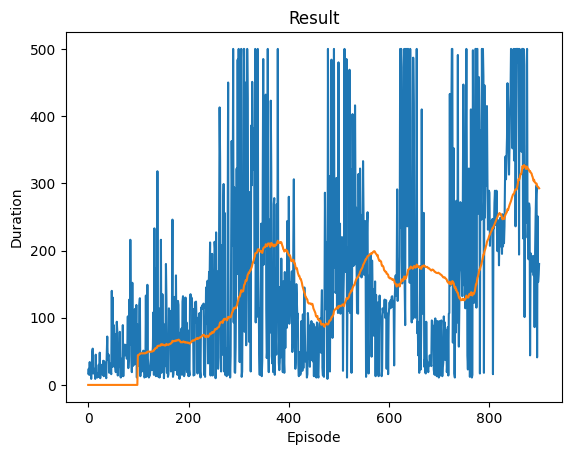

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
# Training Loop

from itertools import count

episode_durations = []

for episode in range(episodes):
    state = env.reset()[0]
    total_reward = 0
    episode_loss = 0

    # Render the environment
    env.render()

    for t in count():
        
        action = act(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)

        done = terminated or truncated
        
        remember(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        # Perform a replay (train the model)
        loss = optimize_model()

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Decay epsilon (for exploration vs exploitation)
    epsilon = max(epsilon_min, epsilon_decay * epsilon)

    # Update target network periodically
    if episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

env.close()
plot_durations(show_result=True)
plt.ioff()
plt.show()